Материал распространяется по  лицензии Creative Commons Attribution license, CC-BY 4.0; code under MIT license. 

Оригинальный курс (c)2014 Lorena A. Barba. Thanks: Gilbert Forsyth and Olivier Mesnard, and NSF for support via CAREER award #1149784.

Перевод (c) 2018 Innokentiy Kursakov

##### Version 0.1 Январь 2018

# Источник и сток

Это первый блокнот из серии *AeroPython*, посвященной изучению классической аэродинамики при помощи Python. Если вы не уверены в своих знаниях основ научных библиотек Python, начните с [*Ликбеза по Python*](00_Lesson00_QuickPythonIntro.ipynb), изложенного во вводном занятии данной серии.

За ходом изложения материала можно следить, просматривая этот блокнот онлайн, при этом набирая исходный код примеров и упражнений в собственном блокноте Jupyter или в отдельном файле в вашей любимой IDE. В любом случае, необходимо, чтобы приведенные здесь примеры были повторены вами самостоятельно.

## Введение

Классическая аэродинамика основывается на *теории потенциального течения*. Математический аппарат, разработанный в рамках этой теории, был движущей силой аэродинамики в эпоху ее становления в 20 веке.

В её основе лежат некоторые предположения:

* поток стационарный;
* скорости течения много меньше скорости звука (несжимаемая жидкость);
* в жидкости отсутствует трение (идеальная жидкость);
* завихренность также отсутствует (жидкие частицы не вращаются).

Может показаться, что упрощений многовато, но, оказывается, значительная часть течений может быть рассмотена в таких предположениях. Роль вязкости велика лишь в очень тонкой области пограничного слоя, и существуют поправки к потенциальной теории, позволяющие учесть это влияние. Течение во многих практических случаях можно считать безвихревым за исключением изолированных точек, линий или поверхностей. И, наконец, большинство интересующих нас случаев относятся к дозвуковым течениям.

У теории потенциального течения есть одно невероятно удобное математическое свойство: *линейность*. Это означает, что применим принцип суперпозиции, и новые решения можно получать как сумму уже известных.

В этом блокноте вы познакомитесь с двумя элементарными потенциальными течениями: **источником** и **стоком**. А затем мы соединим их, и получим еще одно решение.

## Математическая постановка
---

Давайте запишем пару формул. Из курса гидродинамики вам должно быть известно определение *циркуляции*:

$$\Gamma = \oint \mathbf{v}\cdot d\vec{l}$$

По определению, циркуляция это криволинейный интеграл второго рода скорости по замкнутому контуру. Если напрячься, можно вспомнить также теорему Стокса. Она гласит, что криволинейный интеграл по замкнутому равен *потоку ротора* скорости через поверхность, ограниченную этим контуром. Ротор скорости, в свою очередь, это завихренность, $\omega=\nabla\times\mathbf{v}$:

$$\oint \mathbf{v}\cdot d\vec{l} = \int \int_s \omega\cdot \vec{n}~ ds$$

Если завихренность равна нулю (безвихревое течение), то циркуляция по любому замкнутому контуру равна нулю. Это означает, что криволинейный интеграл по любому контуру, соединяющему точки A и B, равен по абсолютному значению и противоположен по знаку интегралу по контуру, соединяющему точки B и A. Раскрыв скалярное произведение вектора скорости $\mathbf{v}=(u,v,w)$, запишем

$$\int_A^B \mathbf{v}\cdot d\vec{l} = \int_A^B u~dx + v~dy + w~dz$$

В безвихревом течении значение этого интеграла не зависит от выбора контура между A и B. А это, как нам должно быть известно из мат. анализа, означает, что $u~dx + v~dy + w~dz~$ является [полным дифференциалом](http://www.wolframalpha.com/input/?i=exact+differential) потенциала $\phi$, где

$$u=\frac{\partial \phi}{\partial x}, \quad v=\frac{\partial \phi}{\partial y}, \quad w=\frac{\partial \phi}{\partial z}$$

Или короче: $\mathbf{v}=\nabla \phi$. Подставив сюда уравнение неразрывности для несжимаемой жидкости $\nabla\cdot\mathbf{v}=0$, мы получим удивительное в своей простоте уравнение потенциального течения:

$$\nabla^2\phi=0$$

*Уравнение Лапласа!* Таким образом любое решение уравнения Лапласа соответствует потенциальному течению.


## Приступим!

Мы хотим получить два решения уравнения Лапласа — потенциалы **источника** и **стока**, для того, чтобы визуализировать поля этих потенциальных течений и насладиться результатом. 

Начнем с импорта нескольких полезных питоновских библиотек:

* NumPy — научная библиотека для работы с многомерными массивами и матрицами;
* Matplotlib — бибилиотека для создания двумерной графики, при помощи которой мы будем визуализировать наши результаты;
* Модуль `math` делает доступными математические функции из стандарта C.

Если вы не помните зачем и как импортировать библиотеки, вернитесь к *вводному занятию*, [Ликбез по Python](00_Lesson00_QuickPythonIntro.ipynb):

In [1]:
import math
import numpy
from matplotlib import pyplot

Наша цель — нарисовать линии тока для источника и стока. Для этого сначала зададим множество точек, в которых будут рассчитаны компоненты скорости. 

Определим декартову сетку, состоящую из равномерно распределённых по расчетной области точек. В качестве расчетной области выберем прямоугольник со сторонами 4 по оси $x$ и 2 по оси $y$: $x,y\in\left[-2,2\right],\left[-1,1\right]$.

Число точек обозначим переменной `N`, а границы расчетной области — переменными `x_start`, `x_end`, `y_start` и `y_end`.

Для создания одномерных массивов, содержащих равномерно распределённые значения по координатам $x$ и $y$ восползуемся функцией [`linspace()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html). В последней строке кода, приведенного в следующем блоке, вызывается функция [`meshgrid()`](http://docs.scipy.org/doc/numpy-1.4.x/reference/generated/numpy.meshgrid.html), создающая двумерные массивы с координатами точек, в которых мы будем вычислять скорости. Убедитесь, что вы понимаете, что делает эта функция и какой результат она возвращает. Мы будем часто её использовать.

In [2]:
N = 50                                # число точек в каждом направлении
x_start, x_end = -2.0, 2.0            # границы по оси x
y_start, y_end = -1.0, 1.0            # границы по оси y
# создаем одномерный массив с координатами x
x = numpy.linspace(x_start, x_end, N)    
# создаем одномерный массив с координатами y
y = numpy.linspace(y_start, y_end, N)    
print('x = ', x)
print('y = ', y)

X, Y = numpy.meshgrid(x, y)              # создаем сетку

x =  [-2.         -1.91836735 -1.83673469 -1.75510204 -1.67346939 -1.59183673
 -1.51020408 -1.42857143 -1.34693878 -1.26530612 -1.18367347 -1.10204082
 -1.02040816 -0.93877551 -0.85714286 -0.7755102  -0.69387755 -0.6122449
 -0.53061224 -0.44897959 -0.36734694 -0.28571429 -0.20408163 -0.12244898
 -0.04081633  0.04081633  0.12244898  0.20408163  0.28571429  0.36734694
  0.44897959  0.53061224  0.6122449   0.69387755  0.7755102   0.85714286
  0.93877551  1.02040816  1.10204082  1.18367347  1.26530612  1.34693878
  1.42857143  1.51020408  1.59183673  1.67346939  1.75510204  1.83673469
  1.91836735  2.        ]
y =  [-1.         -0.95918367 -0.91836735 -0.87755102 -0.83673469 -0.79591837
 -0.75510204 -0.71428571 -0.67346939 -0.63265306 -0.59183673 -0.55102041
 -0.51020408 -0.46938776 -0.42857143 -0.3877551  -0.34693878 -0.30612245
 -0.26530612 -0.2244898  -0.18367347 -0.14285714 -0.10204082 -0.06122449
 -0.02040816  0.02040816  0.06122449  0.10204082  0.14285714  0.18367347
  0.2244898   0.

Созданную расчётную сетку можно визуализировать при помощи модуля `pyplot` из библиотеки `matplotlib`, используя функцию [`scatter()`](http://matplotlib.org/api/pyplot_api.html?highlight=scatter#matplotlib.pyplot.scatter).

Стоит отметить, что мы довольно детально описываем, как именно должна выглядеть желаемое изображение: мы хотим видеть рисунок определенного размера, с подписями к осям, при этом диапазон на осях тоже задан. Даже [цвет маркеров](http://matplotlib.org/api/colors_api.html?highlight=color#module-matplotlib.colors) определен. Изучив все тонкости документации Matplotlib,  вы научитесь создавать радующие глаз иллюстрации высокого качества.

Для того, чтобы картинки отображались в блокноте, вначале нужно использовать [магическую](http://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=magic) комманду `%matplotlib inline`.Тогда результаты работы графического модуля будут вставлены в страницу в виде статических изображений в формате PNG:

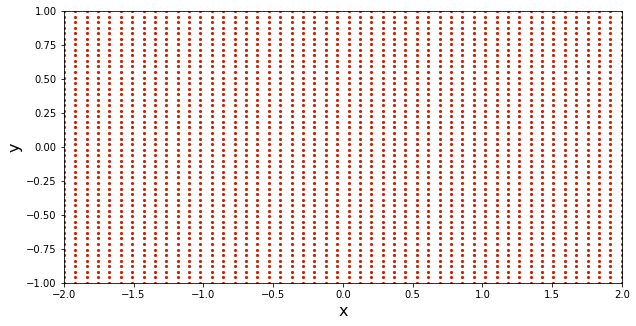

In [3]:
%matplotlib inline

# рисуем сетку из узлов
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.scatter(X, Y, s=10, color='#CD2305', marker='o', linewidth=0)

В каждой из этих выстроенных в ряды точек мы теперь вычислим скорсть, соответствующую течению с источником, а затем нарисуем линии тока.

## Источник

Выше уже упоминалось об одном приятном свойстве потенциальных течений: поскольку они описываются *линейным* уравнением, решения можно получать при помощи суперпозиции. Поэтому очень полезно иметь набор элементарных решений, который можно использовать как кубики. Источники и стоки как раз и являются такими элементарными решениями.

*Источник* это точка, из которой истекает однородный поток жидкости. Из этой точки испускаются линии тока в виде прямых Рассмотрим двумерную постановку. Задача осесимметричная, поэтому воспользуемся полярными координатами $\left(r,\theta\right)$. Угол $\theta$ равен $\arctan(y/x)$. 

Запишем условие отсутсвия завихренности  $\omega=0$ в полярных координатах:

$$\frac{\partial\left(r u_\theta\right)}{\partial r} - \frac{\partial u_r}{\partial \theta} = 0$$

Поскольку азимутальная компонента $u_\theta$ равна нулю, то $\frac{\partial u_r}{\partial \theta} = 0$ — радиальная скорость зависит только от радиуса, $u_r = f(r)$.

Теперь запишем уравнение неразрывности:

$$\frac{\partial\left(r u_r\right)}{\partial r} + \frac{\partial u_\theta}{\partial \theta} = 0$$

C учетом равенства нулю азимутальной компоненты и зная характер зависимости радиальной, это уравнение можно преобразоват в ОДУ $\frac{d(ru_r)}{dr}=0$. Раскрыв скобки, получим:

$$u_r+r\frac{du_r}{dr} = 0$$

Решение этого уравнения $u_r = \frac{const}{r}$. Окончательно радиальная и азимутальная компоненты скорости записываются как 

$$u_r\left(r,\theta\right) = \frac{\sigma}{2\pi r} \text{,} \qquad u_\theta\left(r,\theta\right)=0$$

где $\sigma$ обозначает *интенсивность* источника. Такой выбор константы станет понятен позже.

Надеюсь, вы помнте, что кроме потенциала, существует ещё *функция тока* $\psi$. В полярных координатах соотношения для компонент скорости и $\psi$ выглядят следующим образом:

$$\frac{1}{r}\frac{\partial\psi}{\partial\theta} = u_r \quad \text{,} \quad -\frac{\partial\psi}{\partial r} = u_\theta$$

Интегрирование этих соотношений дает

$$\psi = \frac{\sigma}{2\pi}\theta + \text{constant}$$

На практике интерес представляют как раз компоненты скорости, являющиеся произвоными функции тока, поэтому константу интегрирования можно смело опустить.

В декартовых координатах поле скорости $\left(u,v\right)$ в точке $\left(x,y\right)$, соответствующее источнику с интенсивностью $\sigma$ записывается в виде

$$u = \frac{\partial\psi}{\partial y} = \frac{\sigma}{2\pi}\frac{x-x_\text{source}}{\left(x-x_\text{source}\right)^2+\left(y-y_\text{source}\right)^2}$$

и

$$v = -\frac{\partial\psi}{\partial x} = \frac{\sigma}{2\pi}\frac{y-y_\text{source}}{\left(x-x_\text{source}\right)^2+\left(y-y_\text{source}\right)^2}$$

Рассчитаем скорости в узлах нашей расчётной сетки. Поместим источник в точку $(-1,0)$ и зададим интенсивность $\sigma=5$.

Вместо того чтобы перебирать точки одну за одной в цикле по `[i,j]`, мы сразу вычислим значения массивов (`u_source`, `v_source`), применив к ним арифметические операции. Да, в Numpy арифметические операторы действуют на массив поэлементно, на выходе создаётся новый массив с результатом.

In [4]:
strength_source = 5.0                      # интенсивность источника
x_source, y_source = -1.0, 0.0             # положение источника

# вычисление скорости в узлах расчётной сетки
u_source = strength_source/(2*math.pi) * (X-x_source)/((X-x_source)**2 +\
                                                       (Y-y_source)**2)
v_source = strength_source/(2*math.pi) * (Y-y_source)/((X-x_source)**2 +\
                                                       (Y-y_source)**2)

Пора уже рисовать линни тока! На наше счастье в библиотеке имеется нужная функция [`streamplot()`](http://matplotlib.org/users/whats_new.html#streamplot). Ещё воспользуеся знакомой уже функцией [`scatter()`](http://matplotlib.org/api/pyplot_api.html?highlight=scatter#matplotlib.pyplot.scatter), чтобы обозначить красной точкой положение источника.

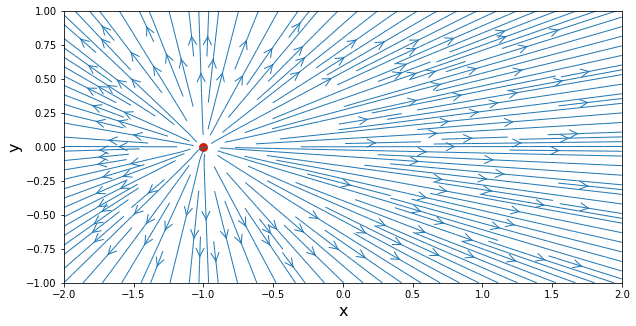

In [5]:
# рисуем линии тока
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u_source, v_source, density=2, \
                  linewidth=1, arrowsize=2, arrowstyle='->')
pyplot.scatter(x_source, y_source, color='#CD2305', s=80, marker='o', \
               linewidth=0);

Здорово. Именно так, как мы и представляли себе источник, только чуточку краше. Обратите внимание, что в конце последней строки мы добавили точку с запятой. Это сделано, чтобы убрать вывод стоки типа `<matplotlib ...>`, в которой указан внутренний идентификатор объекта с рисунком. К примеру, в выводе `Out[3]` такая строка присутствовала.

Предполагается, что просмотрев блокнот, вы подготовите собственную версию. При этом *набирая* код, а не копируя его. Поменяйте параметры, почитайте документацию при необходимости. Дальше мы доберемся до более сложных вопросов, поэтому хотелось бы, чтобы основы были усвоены довольно крепко.

##### Вопрос на понимание происходящего

Чему равен расход черех поверхность (контур), опоясывающую источник?

## Сток

В случае с источником интенсивность была положительной величиной. Если же интенсивность *отрицательная*, получается не источник, а *сток*. Теперь линии тока не испускаются из одной точки, а, наоборот, приходят в неё.

Поле скорости, соответствующее течению со стоком, выглядит аналогично полю с источником, но с противоположным направлением потока. Поэтому код для визуализации картины течения поменяется несильно.

Поместим сток в точку с координатами $(1,0)$, интенсивность оставим такой же, как у источника, поменяем только знак.

In [6]:
strength_sink = -5.0                     # интенсивность стока
x_sink, y_sink = 1.0, 0.0                # положение стока

# вычисление скорости в узлах расчётной сетки
u_sink = strength_sink/(2*math.pi) * (X-x_sink)/((X-x_sink)**2 + \
                                                 (Y-y_sink)**2)
v_sink = strength_sink/(2*math.pi) * (Y-y_sink)/((X-x_sink)**2 + \
                                                 (Y-y_sink)**2)

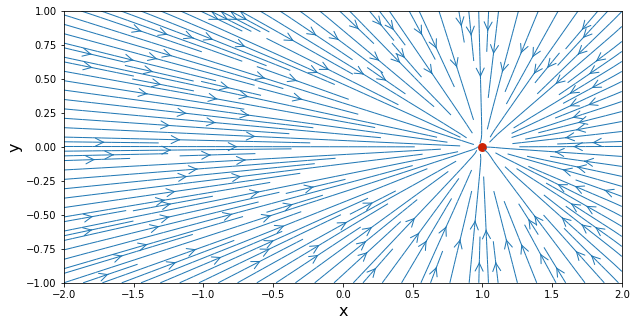

In [7]:
# рисуем линии тока
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u_sink, v_sink, density=2, linewidth=1, \
                  arrowsize=2, arrowstyle='->')
pyplot.scatter(x_sink, y_sink, color='#CD2305', s=80, marker='o', \
               linewidth=0);

## Система источник-сток

А теперь пришло время, чтобы воспользоваться суперпозицией. У нас есть поля скоростей для источника и стока. Сложив эти поля поточечно, получим
новое решение — **систему источник-сток**. Внимательно прочтите приведенный код и убедитесь, что поняли, что там происходит.

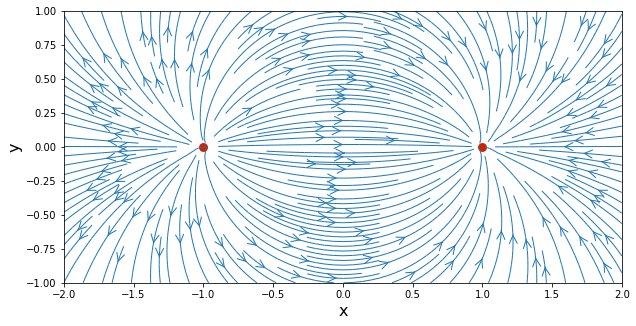

In [8]:
# вычисление скорости для системы источник-сток 
# путем сложения элементарных решений
u_pair = u_source + u_sink
v_pair = v_source + v_sink

# рисуем линии тока системы источник-сток
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u_pair, v_pair, density=2.0, linewidth=1, \
                  arrowsize=2, arrowstyle='->')
pyplot.scatter([x_source, x_sink], [y_source, y_sink], \
            color='#CD2305', s=80, marker='o', linewidth=0);

Поэкспериментируйте! Попробуйте поменять положение источника и стока, их интенсивности. Как меняется картина течения?


##### Задание

Напишите код для визуализации *изолиний потенциала*, вместо линий тока. Вероятно для этого вам потебуется функция [`contour()`](http://matplotlib.org/examples/pylab_examples/contour_demo.html).

---

Не обращайте внимания на следующую ячейку. При её исполнении загружаются стили для отображения блокнота.

In [9]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()